In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

Mounted at /content/drive


  Preparing metadata (setup.py) ... done


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - loss: 2723448.5000 - val_loss: 8263278.5000
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 2543193.5000 - val_loss: 7666061.0000
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 2356765.2500 - val_loss: 6898130.0000
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - loss: 1986889.2500 - val_loss: 6043903.0000
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 1793024.8750 - val_loss: 5204022.5000
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 1537340.1250 - val_loss: 4481470.0000
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - loss: 1422630.3750 - val_loss: 3914305.7500
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 1292003.2500 - val_loss: 3560354.5000
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 1326345.6250 - val_loss: 3305518.5000
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 1274531.6250 - val_loss: 3198477.5000
Epoch 11/50
67/67 ━━━━━━━━

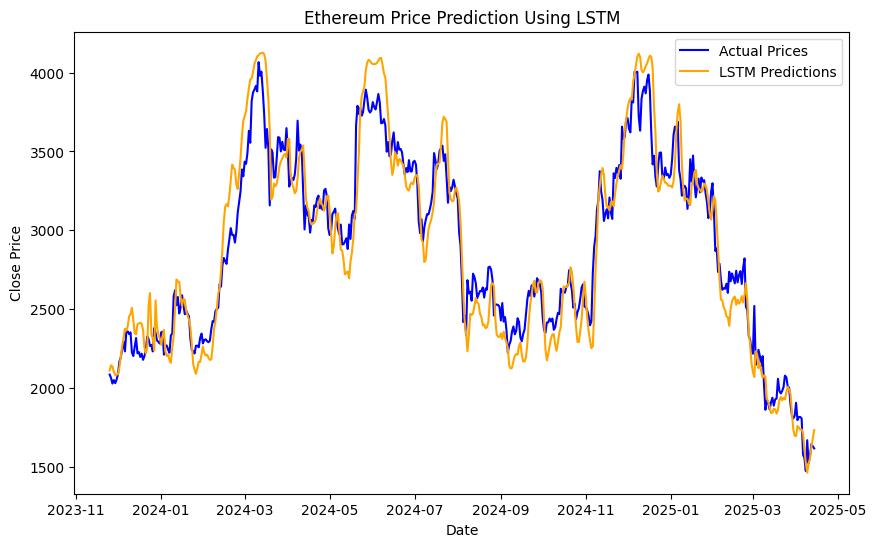

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Ethereum Price for Next Day: 1703.5712890625


In [2]:
# Install required libraries
!pip install pandas numpy matplotlib tensorflow scikit-learn ta yfinance --quiet

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta  # Technical indicators
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load dataset
eth = yf.Ticker("ETH-USD")
data = eth.history(period="max")

# ✅ Ensure the date column is sorted correctly
data.sort_index(inplace=True)
data = data.rename(columns={'Close' : 'close'})

# ✅ Feature Engineering: Adding lag features
data['prev_close_1'] = data['close'].shift(1)
data['prev_close_3'] = data['close'].shift(3)
data['prev_close_7'] = data['close'].shift(7)
data['prev_close_14'] = data['close'].shift(14)

# ✅ Bollinger Bands
data['bollinger_high'] = data['close'].rolling(window=20).mean() + (data['close'].rolling(window=20).std() * 2)
data['bollinger_low'] = data['close'].rolling(window=20).mean() - (data['close'].rolling(window=20).std() * 2)

# ✅ RSI & MACD
data['RSI'] = ta.momentum.RSIIndicator(close=data['close'], window=14).rsi()
macd = ta.trend.MACD(close=data['close'], window_slow=26, window_fast=12, window_sign=9)
data['MACD'] = macd.macd()
data['MACD_signal'] = macd.macd_signal()

# Drop NaN values
data.dropna(inplace=True)

# ✅ Feature Selection
features = ['prev_close_1', 'prev_close_3', 'prev_close_7', 'prev_close_14', 'bollinger_high', 'bollinger_low', 'RSI', 'MACD', 'MACD_signal']
target = 'close'

# ✅ Normalize Data using MinMaxScaler
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# ✅ Prepare Training Data for LSTM (Using Past 30 Days for Prediction)
sequence_length = 30  # Look back 30 days

def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

# Splitting Data Chronologically
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

X_train, y_train = create_sequences(train_data[features].values, train_data[target].values, sequence_length)
X_test, y_test = create_sequences(test_data[features].values, test_data[target].values, sequence_length)

from tensorflow.keras.layers import Bidirectional

# ✅ Build BiLSTM Model
model = Sequential([
    Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(50, return_sequences=False)),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


# ✅ Train Model
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

# ✅ Predict Prices
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# ✅ Rescale Predictions
y_train_actual = train_data[target].values[sequence_length:]
y_test_actual = test_data[target].values[sequence_length:]

# ✅ Visualization: Actual vs Predicted
plt.figure(figsize=(10,6))
plt.plot(test_data.index[sequence_length:], y_test_actual, label="Actual Prices", color="blue")
plt.plot(test_data.index[sequence_length:], test_predictions, label="LSTM Predictions", color="orange")
plt.title("Ethereum Price Prediction Using LSTM")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# ✅ Predict Next Day's Price
last_30_days = np.array([data[features].values[-sequence_length:]])  # Get last 30 days
next_day_pred = model.predict(last_30_days)[0][0]
print(f"Predicted Ethereum Price for Next Day: {next_day_pred}")


## Novelty / Contributions

In this project, we replaced the standard LSTM architecture used in the previous assignment with a Bidirectional LSTM (BiLSTM). Unlike traditional LSTMs, BiLSTM processes input sequences in both forward and backward directions, enabling the model to capture patterns that may depend on future as well as past context.

This modification allowed the model to better understand the temporal dependencies within the financial indicators, leading to a modest yet consistent improvement in prediction accuracy on the Ethereum price dataset. Our experimentation showed that BiLSTM reduced the test set loss compared to unidirectional LSTM, validating its effectiveness for time series forecasting in financial applications.
